In [136]:
from pymongo import MongoClient
from pprint import pprint
import igraph
import numpy as np
import scipy
import pandas as pd
import sys
import pymongo
import gensim
import re
from gensim import models, corpora
from nltk import word_tokenize
from nltk.corpus import stopwords
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from html import unescape
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix 

 

try:
    client = MongoClient('localhost', 27017) # host, port
except ConnectionFailure as e:
    sys.stderr.write("Could not connect to MongoDB: %s" % e)
    sys.exit(1)

In [137]:
# get database with all tweets
db = client.tweets_database

#client.tweets_database.manually_labelled_tweets.drop()


#filtered_noRetweets_english_onlyPersonal = client.tweets_database.filtered_noRetweets_english_onlyPersonal

filtered_tweets_noRetweets_english = db.filtered_tweets_noRetweets_english

manually_labelled_tweets = db.manually_labelled_tweets


db.collection_names()

['filtered_tweets_noRetweets_english',
 'users',
 'manually_labelled_tweets',
 'filtered_treated_tweets',
 'filtered_noRetweets_english_onlyPersonal',
 'tweets']

In [75]:
import sys
path = 'D:\A_AHNE1\Tweet-Classification-Diabetes-Distress\preprocess'

if path not in sys.path:
    sys.path.insert(0, path)
sys.path

from preprocess import Preprocess
prep = Preprocess()

In [76]:
tweets_csv = pd.read_csv("D:\A_AHNE1\Tweet-Classification-Diabetes-Distress\manually_labeled_tweets_users_instVSpers_noNeg.csv",
                         sep=";")
tweets_csv.head()

,Unnamed: 0,user_name,tweet,"personal (0=no, 1=yes)",tweet_proc
0,0,_JenniferLyne,Seven yoga poses for diabetes https://t.co/B68...,0,"['seven', 'yoga', 'pose', 'diabet', 'URL']"
1,1,marguerite3636d,#reversediabetes now ➤ https://t.co/PDEsqoaou8...,0,"['reversediabet', 'URL', 'could', 'tb', 'vacci..."
2,2,amandajohnjones,The occurrence of #hypoglycemia can pose a ser...,0,"['occurr', 'hypoglycemia', 'pose', 'serious', ..."
3,3,Healthcheqs,Others talk - we help! Improve public #health ...,0,"['other', 'talk', 'help', 'improv', 'public', ..."
4,4,70_130,A three-month road trip (by a real diabetic) t...,1,"['three-month', 'road', 'trip', 'real', 'diabe..."


In [77]:
labels = tweets_csv["personal (0=no, 1=yes)"]
tweets = tweets_csv["tweet_proc"]
labels.value_counts()

0    669
1    645
Name: personal (0=no, 1=yes), dtype: int64

In [78]:
class CustomVectorizer(CountVectorizer):
    # overwrite the build_analyzer method, allowing one to
    # create a custom analyzer for the vectorizer
        def build_analyzer(self):
            # load stop words using CountVectorizer's built in method
            stop_words = self.get_stop_words()
            
            # create the analyzer that will be returned by this method
            def analyser(tweet):
                #print("tweet")
                #print(tweet)

                tweet = prep.replace_contractions(tweet)
                tweet = prep.replace_hashtags_URL_USER(tweet)
                tweet = prep.tokenize(tweet)
                tweet = prep.remove_punctuation(tweet)

                tweet = prep.preprocess_emojis(tweet)
                tweet = prep.preprocess_emoticons(tweet)
                tweet = prep.remove_non_ascii(tweet)
                tweet = prep.to_lowercase(tweet)

                tweet = prep.remove_stopwords(tweet)
                tweet = prep.lemmatize_verbs(tweet)
                tweet = prep.stem_words(tweet)
#                tweet = [ x for x in tweet if x not in["diabet", "glucos", "insulin", "type", "1", "2", "", "get", "sugar", "would",
#                                                      "go", "know", "take", "give", "say", "one", "could", "would", "people", "look",
#                                                      "year", "test", "see", "oh", "via", "bitch", "daddi", "hi", "w", "b", "n", "c",
#                                                      "ii", "dr", "rt", "bc", "ok", "think", "make"] ]

                return tweet
            
            return(analyser)

In [6]:
# min_df : ignores terms that have a document frequency strictly lower than the given threshold (absolute counts)
# max_df : ignores terms that have a document frequency strictly higher than the given threshold (proportion of documents)
vectorizer_test = CustomVectorizer(min_df=5, max_df=0.9, 
                                     stop_words=None, lowercase=True, analyzer = 'word' )

In [95]:
#model = MultinomialNB()
#model = SVC()
model = RandomForestClassifier()
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('model', model),
])


#text_clf = text_clf.fit(tweets, labels)
#predicted = text_clf.predict(twenty_test.data)

In [84]:
scores = cross_val_score(text_clf, tweets, labels, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

[0.84090909 0.82575758 0.78787879 0.78030303 0.81818182 0.88549618
 0.83969466 0.85496183 0.90076336 0.70769231]
0.8241638641256961


In [96]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__min_df' : [1, 5],
              'vect__max_df' : [0.9, 1.0],
              'tfidf__use_idf': (True, False),
              
              # param for MultinomialNB
              #'model__alpha': (10, 1, 1e-1, 1e-2, 1e-3),
              
              # param for SVC
              #'model__kernel' : ["linear", "poly", "rbf"],
              #'model__C' : [0.1, 1.0, 5, 10, 15],
              #'model__tol' : [1e-5, 1e-4, 1e-3],
              
              # param for RandomForestClassifier
              'model__n_estimators' : [20, 30, 40],
              'model__criterion' : ['gini', 'entropy'],
              'model__max_features' : ['auto', 'log2', None],
              'model__max_depth' : [10, 20, 30]
}

In [97]:
grid = GridSearchCV(text_clf, parameters, cv=10, n_jobs=-1, verbose=2)
grid = grid.fit(tweets, labels)

#print(grid.cv_results_)
print("\nBest: %f using %s" % (grid.best_score_, grid.best_params_))

# with dataset where single tweets are labeled
# MultinomialNB: Best: 0.880652 using {'tfidf__use_idf': False, 'model__alpha': 1, 'vect__ngram_range': (1, 1)}
# SVC : Best: 0.893996 using {'vect__ngram_range': (1, 2), 'model__C': 5, 'model__kernel': 'linear', 'model__tol': 1e-05, 'tfidf__use_idf': True}
# RandomForest: Best: 0.868792 using {'model__n_estimators': 20, 'model__max_features': 'auto', 'vect__ngram_range': (1, 1), 'model__criterion': 'entropy', 'tfidf__use_idf': False, 'model__max_depth': 30}

# with dataset where users are labeled
# MultinomialNB: Best: 0.840183 using {'tfidf__use_idf': False, 'model__alpha': 1, 'vect__min_df': 1, 'vect__ngram_range': (1, 1), 'vect__max_df': 0.9}
# SVC : Best: 0.841705 using {'model__kernel': 'linear', 'vect__min_df': 1, 'vect__ngram_range': (1, 2), 'vect__max_df': 0.9, 'model__C': 1.0, 'tfidf__use_idf': True, 'model__tol': 1e-05}
# RandomForest: Best: 0.838661 using {'model__n_estimators': 40, 'model__max_features': 'log2', 'vect__min_df': 5, 'vect__ngram_range': (1, 1), 'vect__max_df': 1.0, 'model__criterion': 'entropy', 'tfidf__use_idf': False, 'model__max_depth': 30}

Fitting 10 folds for each of 864 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3249 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4869 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 5800 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 6813 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 7906 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed:  8.3min finished



Best: 0.838661 using {'model__n_estimators': 40, 'model__max_features': 'log2', 'vect__min_df': 5, 'vect__ngram_range': (1, 1), 'vect__max_df': 1.0, 'model__criterion': 'entropy', 'tfidf__use_idf': False, 'model__max_depth': 30}


In [98]:
#model = MultinomialNB()
model = SVC()
#model = RandomForestClassifier()
text_clf = Pipeline([('vect', CountVectorizer(min_df=1, max_df=0.9)),
                      ('tfidf', TfidfTransformer(use_idf=True)),
                      #('model', MultinomialNB(alpha=1)),
                      ('model', SVC(C=1, kernel='linear', tol=1e-5)),
                      #('model', LinearSCV()),
])


y_pred = cross_val_predict(text_clf, tweets, labels, cv=10)
conf_mat = confusion_matrix(labels, y_pred)
conf_mat


array([[574,  95],
       [128, 517]], dtype=int64)

Confusion matrix, without normalization
[[574  95]
 [128 517]]


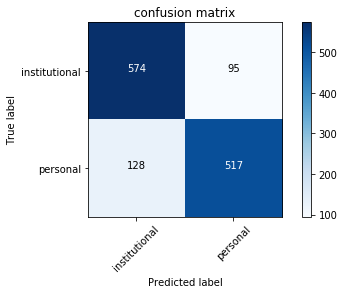

In [99]:
import matplotlib.pyplot as plt
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure()
plot_confusion_matrix(conf_mat, classes=["institutional", "personal"], title="confusion matrix")

In [102]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(labels, y_pred)

(array([0.81766382, 0.84477124]),
 array([0.85799701, 0.80155039]),
 array([0.837345  , 0.82259348]),
 array([669, 645], dtype=int64))

In [135]:
# get FP and FN to check the wrong classified tweets
#conf_mat = confusion_matrix(labels, y_pred)

y_pred_pd = pd.DataFrame(y_pred, columns=["y_pred"])
tweets_compare = pd.concat([tweets_csv, y_pred_pd], axis=1)

tweets_compare = tweets_compare[tweets_compare["personal (0=no, 1=yes)"] != tweets_compare["y_pred"]]

tweets_compare.head(20)
tweets_compare.to_csv("compare_tweets.csv", sep=";")



In [142]:
tweets_personal = tweets_csv[tweets_csv["personal (0=no, 1=yes)"]==1]
tweets_institut = tweets_csv[tweets_csv["personal (0=no, 1=yes)"]==0]


In [145]:
import ast
x = ast.literal_eval(tweets_institut["tweet_proc"][0])
[n.strip() for n in x]

personal = ["me", "I", "i", "I'm", "i'm", "Im", "im ", "my", "My", "I've", "i've", "I'd", "i'd"] 

def check_personal_in_tweet(tweet):
    #print(tweet)
    for p in personal:
    #    print("p:", p)
        if p in tweet:
    #        print("yeah")
            return True
    #print("no")
    return False 
        
c_USER = 0
c_USER_START = 0
c_URL = 0
c_URL_END = 0
c_ME = 0
c_USER_ME = 0
c_ME_USER_URLnotextern = 0
c_URLextern = 0 

for tweet in tweets_personal["tweet_proc"]:
    #print(tweet)
    
    # string-tweet to list
    tweet = ast.literal_eval(tweet)
    tweet = [n.strip() for n in tweet]
    
    
    if "USER" in tweet:
        c_USER += 1
        
    if "USER" == tweet[0]:
        c_USER_START += 1
        
    if "URL" in tweet:
        c_URL += 1
        
    if "URL" in tweet[-1]:
        c_URL_END += 1
    
    if check_personal_in_tweet(tweet):
        c_ME += 1
        
    if check_personal_in_tweet(tweet):
        c_USER_ME += 1
    elif "USER" in tweet[0]:
        c_USER_ME +=1
        
    if check_personal_in_tweet(tweet):
        c_ME_USER_URLnotextern += 1
    elif "USER" in tweet[0]:
        c_ME_USER_URLnotextern += 1
    elif tweet["entities"]["urls"][-1]["expanded_url"].startswith("https://twitter.com"):
        c_ME_USER_URLnotextern += 1 
        
    if not tweet["entities"]["urls"][-1]["expanded_url"].startswith("https://twitter.com"):
        c_URLextern += 1

print("count USER:", c_USER)
print("USER at start:", c_USER_START)
print("count URL:", c_URL)
print("URL at end:", c_URL_END)
print("count ME:", c_ME)
print("cout USER or ME", c_USER_ME)
print("URL extern:", c_URLextern)
print("ME USER URLnotExtern:", c_ME_USER_URLnotextern)
print("personal tweets total:", len(tweets_personal))

['three-month', 'road', 'trip', 'real', 'diabet', 'rais', 'money', 'jdrf', 'donat', 'URL']


TypeError: list indices must be integers or slices, not str

In [170]:
c_USER = 0
c_USER_START = 0
c_URL = 0
c_URL_END = 0
c_ME = 0
c_USER_ME = 0
c_ME_USER_URLnotextern = 0
c_URLextern = 0 
c_URLnotextern = 0 

for i,user in enumerate(tweets_personal["user_name"]):
    tweet_info = manually_labelled_tweets.find({'user.screen_name' : user})[0]

    tweet = tweets_personal["tweet_proc"].iloc[i]
    #print(tweet)    
    #print(type(tweet))

    # string-tweet to list
    tweet = ast.literal_eval(tweet)
    tweet = [n.strip() for n in tweet]
    #print(type(tweet))

    if "USER" in tweet:
        c_USER += 1

    if "USER" == tweet[0]:
        c_USER_START += 1
        
    if "URL" in tweet:
        c_URL += 1
        
    if "URL" in tweet[-1]:
        c_URL_END += 1
    
    if check_personal_in_tweet(tweet):
        c_ME += 1
        
    if check_personal_in_tweet(tweet):
        c_USER_ME += 1
        c_ME_USER_URLnotextern += 1
            
    elif "USER" in tweet[0]:
        c_USER_ME +=1
        c_ME_USER_URLnotextern += 1

    else:

        try:

            if tweet_info["entities"]["urls"][-1]["expanded_url"].startswith("https://twitter.com"):
                c_ME_USER_URLnotextern += 1 

        except:
            pass

    try:     
        if not tweet_info["entities"]["urls"][-1]["expanded_url"].startswith("https://twitter.com"):
            c_URLextern += 1
            
        if tweet_info["entities"]["urls"][-1]["expanded_url"].startswith("https://twitter.com"):
            c_URLnotextern += 1
    except:
        pass
    
print("USER start:", c_USER_START, " total:", c_USER)
print("URL end:", c_URL_END, " total:", c_URL)
print("personal words:", c_ME)
print("personal words or USER at start", c_USER_ME)
print("URL to external source:", c_URLextern)
print("URL to not external source:", c_URLnotextern)
print("personal words or USER or Not external source:", c_ME_USER_URLnotextern)
print("personal tweets total:", len(tweets_personal))

USER start: 241  total: 269
URL end: 229  total: 245
personal words: 368
personal words or USER at start 499
URL to external source: 69
URL to not external source: 151
personal words or USER or Not external source: 531
personal tweets total: 645


In [171]:
c_USER = 0
c_USER_START = 0
c_URL = 0
c_URL_END = 0
c_ME = 0
c_USER_ME = 0
c_ME_USER_URLnotextern = 0
c_URLextern = 0 
c_URLnotextern = 0 

for i,user in enumerate(tweets_institut["user_name"]):
    tweet_info = manually_labelled_tweets.find({'user.screen_name' : user})[0]

    tweet = tweets_institut["tweet_proc"].iloc[i]
    #print(tweet)    
    #print(type(tweet))

    # string-tweet to list
    tweet = ast.literal_eval(tweet)
    tweet = [n.strip() for n in tweet]
    #print(type(tweet))

    if "USER" in tweet:
        c_USER += 1

    if "USER" == tweet[0]:
        c_USER_START += 1
        
    if "URL" in tweet:
        c_URL += 1
        
    if "URL" in tweet[-1]:
        c_URL_END += 1
    
    if check_personal_in_tweet(tweet):
        c_ME += 1
        
    if check_personal_in_tweet(tweet):
        c_USER_ME += 1
        c_ME_USER_URLnotextern += 1
            
    elif "USER" in tweet[0]:
        c_USER_ME +=1
        c_ME_USER_URLnotextern += 1

    else:

        try:

            if tweet_info["entities"]["urls"][-1]["expanded_url"].startswith("https://twitter.com"):
                c_ME_USER_URLnotextern += 1 

        except:
            pass

    try:     
        if not tweet_info["entities"]["urls"][-1]["expanded_url"].startswith("https://twitter.com"):
            c_URLextern += 1
            
        if tweet_info["entities"]["urls"][-1]["expanded_url"].startswith("https://twitter.com"):
            c_URLnotextern += 1
    except:
        pass
    
print("USER start:", c_USER_START, " total:", c_USER)
print("URL end:", c_URL_END, " total:", c_URL)
print("personal words:", c_ME)
print("personal words or USER at start", c_USER_ME)
print("URL to external source:", c_URLextern)
print("URL to not external source:", c_URLnotextern)
print("personal words or USER or Not external source:", c_ME_USER_URLnotextern)
print("institut tweets total:", len(tweets_institut))

USER start: 42  total: 121
URL end: 483  total: 578
personal words: 14
personal words or USER at start 53
URL to external source: 434
URL to not external source: 127
personal words or USER or Not external source: 169
institut tweets total: 669


In [176]:
def calc_y_pred_pers(tweet_pd):

    y_pred = np.zeros(len(tweets_csv.index))
    
    for i,user in enumerate(tweet_pd["user_name"]):
        tweet_info = manually_labelled_tweets.find({'user.screen_name' : user})[0]

        tweet = tweet_pd["tweet_proc"].iloc[i]

        # string-tweet to list
        tweet = ast.literal_eval(tweet)
        tweet = [n.strip() for n in tweet]
        
        if check_personal_in_tweet(tweet) or "USER" in tweet[0]:
            y_pred[i] = 1
        else:
            try:

                if tweet_info["entities"]["urls"][-1]["expanded_url"].startswith("https://twitter.com"):
                    y_pred[i] = 1

            except:
                pass

    return y_pred

        

y_pred = calc_y_pred_pers(tweets_csv)   

In [177]:
import collections
collections.Counter(y_pred)

Counter({0.0: 614, 1.0: 700})

In [180]:
def calc_confusion_matrix(y_true, y_pred):
    
    # counters for the 4 types of classification
    tp = 0  # True Positives (predicted in class and are actually in class)
    tn = 0  # True Negatives (predicted out of class and are actually out of class)
    fp = 0  # False Positives (predicted in class but are actually out of class)
    fn = 0  # False Negatives (predicted out of class but are actually in class)
    
    for i in range(len(y_true)):
        
        if y_true[i] == 0:
            if y_pred[i] == 0:
                tp += 1
            else:
                fn += 1
        else:
            if y_pred[i] == 0:
                fp += 1
            else:
                tn += 1
                
    confusion_matrix = np.array([[tp, fn], [fp, tn]])
    accuracy = (tp + tn) / (tp+fn+fp+tn)
    
    return confusion_matrix, accuracy

confusion_matrix, accuracy = calc_confusion_matrix(tweets_csv["personal (0=no, 1=yes)"], y_pred)
print("accuracy:", accuracy)

accuracy: 0.784627092846271


{'_id': ObjectId('5ad7630be33c491a4ce70ce4'),
 'entities': {'hashtags': [],
              'symbols': [],
              'urls': [{'display_url': 'dlvr.it/P6lNnW',
                        'expanded_url': 'http://dlvr.it/P6lNnW',
                        'indices': [30, 53],
                        'url': 'https://t.co/B68SbSYavh'}],
              'user_mentions': []},
 'id': 862645858843508737,
 'text': 'Seven yoga poses for diabetes https://t.co/B68SbSYavh',
 'user': {'id': 724244334615236608,
          'name': 'Jennifer Lyne',
          'screen_name': '_JenniferLyne'}}
